In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from scipy.io import loadmat
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

In [2]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2021-09-09 08:19:58--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  6.44MB/s    in 18s     

2021-09-09 08:20:16 (9.92 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-09-09 08:20:16--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  3.92MB/s    in 16s     

2021-09-09 08:20:33 (3.79 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [3]:
class SVHN_dataset(Dataset):

    # def __init__(self, data,transform):
    def __init__(self, data):  
        # Transform data to Torch Tensors
        self.images = torch.tensor(data['X']).permute([3,2,0,1])
        self.labels = torch.tensor(data['y'])
        self.size = self.labels.shape[0]

        # replace label 10 with label 0
        self.labels[self.labels==10] = 0
        # convert to float and normalize images to 0..1 range
        self.images = torch.FloatTensor(self.images/255.)
        # self.transform = transform

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [14]:
class CNN(nn.Module):
  def __init__(self):
        super(CNN,self).__init__()
        #Convolution 1
        self.conv1=nn.Conv2d(in_channels=3,out_channels=6, kernel_size=5,stride=1, padding=2)
        nn.init.normal_(self.conv1.weight, std=0.001)
        nn.init.constant_(self.conv1.bias, 0)
        self.bn1 = nn.BatchNorm2d(6)
        self.relu1= nn.ReLU()
        self.maxpool1= nn.MaxPool2d(kernel_size=2,stride=2)

        #Convolution 2
        self.conv2=nn.Conv2d(in_channels=6,out_channels=12, kernel_size=3,stride=1, padding=1)
        nn.init.normal_(self.conv2.weight, std=0.001)
        nn.init.constant_(self.conv2.bias, 0)
        self.bn2 = nn.BatchNorm2d(12)
        self.relu2= nn.ReLU()
        self.maxpool2= nn.MaxPool2d(kernel_size=2,stride=2)
        
        #Convolution 3
        self.conv3=nn.Conv2d(in_channels=12,out_channels=24, kernel_size=3,stride=1, padding=1)
        nn.init.normal_(self.conv3.weight, std=0.001)
        nn.init.constant_(self.conv3.bias, 0)
        self.bn3 = nn.BatchNorm2d(24)
        self.relu3= nn.ReLU()
        self.maxpool3= nn.MaxPool2d(kernel_size=2,stride=2)
        
        ### fully connected layer
        self.fc_input_size = 24*4*4
        self.fc4 = nn.Linear(self.fc_input_size, 10)
        nn.init.normal_(self.fc4.weight, std=0.001)
        nn.init.constant_(self.fc4.bias, 0)
        
  def forward(self,x):
        # conv layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        
        # final layer
        x = x.view(-1, self.fc_input_size)
        x = self.fc4(x)
        return(x)

In [5]:
def get_accuracy(model,dataloader):
  model.eval()
  with torch.no_grad():
    correct = 0
    batches = 0
    for X_test, y_test in testSVHN_loader:
        X_test_tensor = torch.tensor(X_test, dtype = torch.float)
        y_test_tensor = torch.tensor(y_test, dtype = torch.long)
        images, labels = Variable(X_test_tensor).to(device), Variable(y_test_tensor).to(device)
        outputs = model(images)
        target = labels.squeeze()
        loss = lossfunc(outputs, target)
        _, predicted = torch.max(outputs.data, 1)
        batches += labels.size(0)
        correct += (predicted == target).sum().item()

    # return 100*correct/batches
    return loss.item(),100*correct/batches

In [6]:
# transform = transforms.Compose(
#       [
#         transforms.ToTensor(),
#         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#         ]
#     )

In [7]:
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

In [8]:
print(train['X'].shape)

(32, 32, 3, 73257)


In [9]:
# train_SVHNdataset = SVHN_dataset(data = train, transform = transform)
# test_SVHNdataset = SVHN_dataset(data = test, transform = transform)
train_SVHNdataset = SVHN_dataset(data = train)
test_SVHNdataset = SVHN_dataset(data = test)

In [10]:
params = {'batch_size': 512,
          'shuffle': True,
          'num_workers': 2,
          'pin_memory':True}

In [11]:
trainSVHN_loader = DataLoader(train_SVHNdataset, **params)
testSVHN_loader = DataLoader(test_SVHNdataset, **params)

In [15]:
model = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else cpu)
print(device)

cuda:0


In [16]:
model.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc4): Linear(in_features=384, out_features=10, bias=True)
)

In [17]:
learning_rate = 0.001
lossfunc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [18]:
num_epochs = 50
train_loss_values = []
val_loss_values = []
training_loss = 0
validation_loss = 0
for epoch in range(num_epochs):
    # Training
    # training_loss = 0
    model.train()
    for X_train, y_train in trainSVHN_loader:
      # Transfer to GPU
      X_train_tensor = torch.tensor(X_train, dtype = torch.float)
      y_train_tensor = torch.tensor(y_train, dtype = torch.long)

      images, labels = Variable(X_train_tensor).to(device), Variable(y_train_tensor).to(device)

      # model computation
      optimizer.zero_grad()
      outputs = model(images)
      target = labels.squeeze()
      loss = lossfunc(outputs, target)
      
      loss.backward()
      optimizer.step()

      # training_loss += loss.item()
    # training_loss /= len(trainSVHN_loader)
    if epoch%10==0 :
      train_loss_values.append(loss.item())

      val_loss,val_acc = get_accuracy(model,testSVHN_loader)
    # validation_loss += val_loss
    # validation_loss /= len(testSVHN_loader)
      val_loss_values.append(val_loss)
      print('Epoch -',epoch, 'training loss - ', loss.item(), 'validation loss -', val_loss, 'validation acc -', val_acc)
print('Finished Training')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-pa

Epoch - 0 training loss -  0.8059916496276855 validation loss - 0.9606804251670837 validation acc - 70.14443761524278
Epoch - 10 training loss -  0.34396010637283325 validation loss - 0.41142693161964417 validation acc - 87.12738168408113
Epoch - 20 training loss -  0.367438942193985 validation loss - 0.36712098121643066 validation acc - 87.59987707437
Epoch - 30 training loss -  0.07703963667154312 validation loss - 0.45193400979042053 validation acc - 87.29256299938537
Epoch - 40 training loss -  0.19862151145935059 validation loss - 0.4880758225917816 validation acc - 87.70743700061463
Finished Training


In [19]:
train_loss_values

[0.8059916496276855,
 0.34396010637283325,
 0.367438942193985,
 0.07703963667154312,
 0.19862151145935059]

In [20]:
val_loss_values

[0.9606804251670837,
 0.41142693161964417,
 0.36712098121643066,
 0.45193400979042053,
 0.4880758225917816]

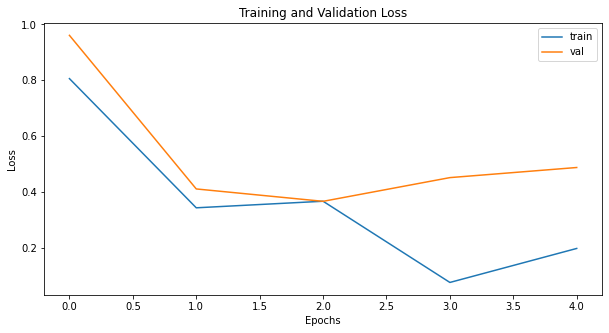

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")

plt.plot(train_loss_values,label="train")
plt.plot(val_loss_values,label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()